In [86]:
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

In [87]:
subject = 1
runs = [4, 8, 12]

raw_filename = eegbci.load_data(subject, runs)
raw_filename


['/Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf',
 '/Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf',
 '/Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf']

In [88]:
raw_edf = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_filename])

Extracting EDF parameters from /Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [89]:
eegbci.standardize(raw_edf) # channels name
raw_edf.rename_channels(lambda x: x.strip('.')) # remove dot from channel name


<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [90]:
raw_edf.filter(7., 30., method='iir', iir_params=None, skip_by_annotation='edge') # keep alpha and beta band with 4th Butterworth

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 30.00 Hz: -6.02, -6.02 dB



<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

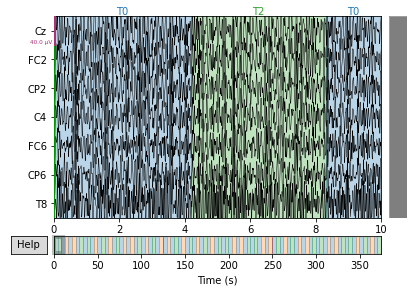

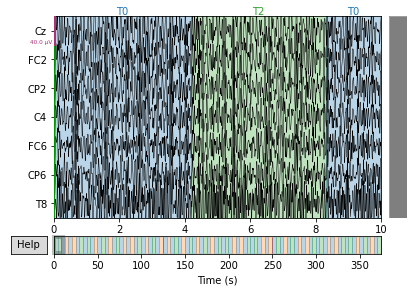

In [91]:
# epochs
selected_channels = [10, 4, 18, 12, 6, 20, 41, 26] # CZ, FC2, CP2, C4, FC6, CP6, T8, AFZ (reference)
raw_edf.pick(picks=selected_channels)
raw_edf.plot()